# Fake news detection machine learning project

### the purpose of this file is to create a machine learning algorithm that will help us to detect  fake news. in order to to do that , I am going to use many tools provide by python and explain each steps so that anyone could be able to understand.

## I/ Dataset import and cleanning

In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('dataset/news.csv')

let us see a brief summary of this dataset.

In [3]:
dataset.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


We can notice many useless features in our case , such as the 'unnamed_0' (wich probably represents the id)

let us see more deeply dataset'informations

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


so our dataset is complete , no missing values

in fact , this dataset has already been cleanned (it's a public one).

In [8]:
labels = dataset.label #target vector

In [9]:
feature = dataset['text'] #features vector

like all ML project , we need to split our dataset into a test set and a train set.

In [11]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(feature , labels , test_size = 0.2)

the strategy I'm going to use is based on the tfidfVectorizer. it allows me to compute word's frequency in each article , and the word's global frequency. some words are overused in fake news .

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(stop_words='english' , max_df=0.72)

In [13]:
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

now we're ready to jump into the second part of this project , the model selection.

## II/ Model selection

in this section , we will create many models and test their accuracy in many ways so that we coul choose the best one at the end.

### 1/ Passive Agressive classifier

In [18]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac = PassiveAggressiveClassifier(max_iter = 50)

In [21]:
from sklearn.model_selection import cross_val_score

val_scores = cross_val_score(pac , X_train_vect , y_train , cv = 10)

In [24]:
def print_val_scores(val_scores):
    print(f'results : {val_scores}\n')
    print(f'mean : {val_scores.mean()}\n')
    print(f'standard deviation : {val_scores.std()}')

In [25]:
print_val_scores(val_scores)

results : [0.94477318 0.93688363 0.94477318 0.93885602 0.93885602 0.94871795
 0.92110454 0.93688363 0.92885375 0.92490119]

mean : 0.9364603066944206

standard deviation : 0.008529754964598936


we can see that this model is really good , 0.936 as mean value for the cross val score is interessting. moere than that , each error in the cross val score is above 0.92

let's see the confusion mattrix.

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

val_predicts = cross_val_predict(pac , X_train_vect , y_train , cv = 10)
pac_conf = confusion_matrix(y_train , val_predicts , labels = ['FAKE' , 'REAL'] )

In [28]:
pac_conf

array([[2397,  132],
       [ 193, 2346]])

this result means that 2397 'FAKE's have bee correctly classified , 2346 'REAL's have been correctly classified

more than that , it means that 193 'FAKE's have been classified as 'REAL , and vice versa for 132 'REAL's

this model seems to have a good potential , in order to get a best one based on passive agressive method , I'm going to use a grid search cv.

In [31]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_iter':[5,10,15,20,25,30,50,60,70,80,100],
    'shuffle':[True , False],
    'fit_intercept':[True , False]
    
}
pac_ = PassiveAggressiveClassifier()
pac_grid = GridSearchCV(pac,param_grid=parameters , cv = 10 , n_jobs=-1 )

In [32]:
pac_grid.fit(X_train_vect , y_train)

GridSearchCV(cv=10, estimator=PassiveAggressiveClassifier(max_iter=50),
             n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'max_iter': [5, 10, 15, 20, 25, 30, 50, 60, 70, 80,
                                      100],
                         'shuffle': [True, False]})

In [33]:
pac_grid.best_params_

{'fit_intercept': True, 'max_iter': 20, 'shuffle': True}

In [34]:
pac_b = pac_grid.best_estimator_

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix_pac = confusion_matrix(y_train , cross_val_predict(pac_b , X_train_vect , y_train , cv  =10) ,
                                  labels = ['FAKE' , 'REAL'])

display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_pac , display_labels=pac_b.classes_)

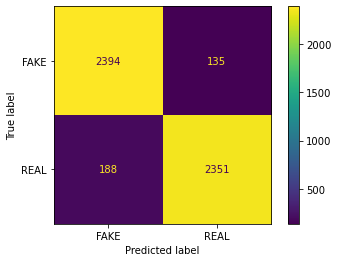

In [42]:
%matplotlib inline

display.plot()

it isn't much better than before , we can deduce that this model reaches alomost is maximum performance.

I care more about false negative than false positive (it means that I'd prefer 'REAL' missClassified as 'FALSE' -- False Positive -- than 'FAKE' missClassified as 'REAL' -- False Negative --). having said that , I'm gonna use the ROC-ROCAUC indications in order to get a model wich cares more about FN.

In [43]:
y_pred_scores = cross_val_predict(pac_b , X_train_vect , y_train , cv = 10 , method = 'decision_function')

In [53]:
from sklearn.metrics import roc_curve , roc_auc_score

# our pac assing a value +1 for a x predicted as False , and -1 otherwise
# in order to plot the roc cure , we have to fit the y_train with this decision function.

y_train_num = y_train.copy().replace(['FAKE'] , -1)
y_train_num = y_train_num.replace(['REAL'] , +1)
fpr , tpr , thresholds = roc_curve(y_train_num , y_pred_scores)

In [54]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr , tpr):

    plt.plot(fpr , tpr , 'g-' , label = 'ROC')
    plt.plot([0,1] , [0,1] , 'k--' , label = 'random classifier')
    plt.xlabel('fale positive rate')
    plt.ylabel(' True positive rate')
    plt.legend()


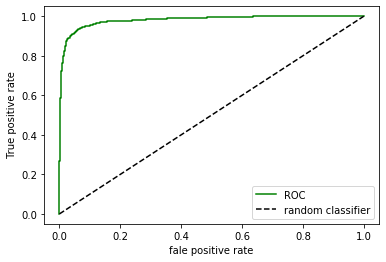

In [55]:
plot_roc_curve(fpr , tpr)

In [56]:
roc_auc_score(y_train_num , y_pred_scores)

0.9809505521690806

really good auc_score , now let's pick a good value for the tpr (wich minimize the false positive)

In [164]:
fpr_max = fpr[np.argmin(tpr <= 0.9)]

In [165]:
fpr_max

0.03598260181890075

In [181]:
thresholds_prec = thresholds[np.argmin(tpr <= 0.9)]
print(thresholds_94_prec)

0.17718100022265154


it means that , if I want a tpr at 90% I have to set the threshold of my pac at thresholds_prec . in order to reduce the number of false negative I have to reduce the tpr as well.

let's try it and see the final result for this classifier

In [182]:
y_pred_ = y_pred_scores.copy()
y_pred_[y_pred_ < thresholds_prec] = -1
y_pred_[y_pred_ >= thresholds_prec] = 1

In [183]:
y_pred_

array([-1.,  1.,  1., ..., -1., -1.,  1.])

In [184]:
y_pred_scores

array([-1.9306537 ,  2.12162279,  0.81307616, ..., -0.17334062,
       -0.37624595,  2.05554198])

In [185]:
y_pred_ = y_pred_.astype(np.int64)
y_pred_ = pd.DataFrame(y_pred_ , columns = ['label'])
y_pred_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5068 entries, 0 to 5067
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   5068 non-null   int64
dtypes: int64(1)
memory usage: 39.7 KB


In [186]:
cmd = ConfusionMatrixDisplay(
                    confusion_matrix=confusion_matrix(pd.DataFrame(y_train_num) , y_pred_ , labels = [-1 , 1]),
                    display_labels=pac_b.classes_
)

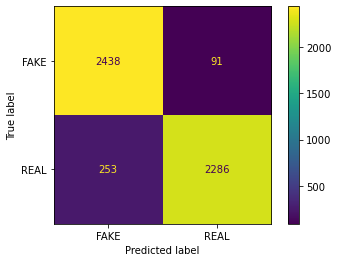

In [187]:
cmd.plot()

and that's exactly wath I want. less fake have been classified as Real , even though more real 've been classified as fake.

now , let's test our model in real data and plot the confusion matrix.

In [179]:
y_pred = pac_b.decision_function(X_test_vect)

In [188]:
y_pred = (y_pred > thresholds_prec)

In [191]:
y_pred = pd.DataFrame(y_pred , columns = ['label'])['label'].replace([1.0] , int(1) )

In [196]:
y_pred = y_pred.replace([0.0] , int(-1))

In [199]:
y_pred = y_pred.astype(np.int64)

In [201]:
y_test_ = y_test.copy()
y_test_ = y_test_.replace(['FAKE'] , -1)
y_test_ = y_test_.replace(['REAL'] , +1)

In [203]:
cmd = ConfusionMatrixDisplay(
                    confusion_matrix=confusion_matrix(y_test_ , y_pred , labels = [-1 , 1]),
                    display_labels=pac_b.classes_
)

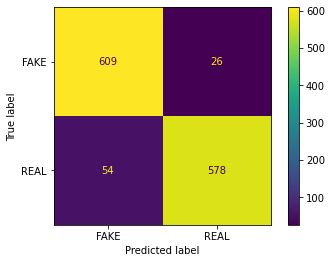

In [204]:
cmd.plot()

in a nutshell , using a passing agressive algorithm , we classified 609 fake news as fake news , 578 real news as real , 54 real's as fake , and 26 fake as real.